# House Prices - Data Preprocessing

Based on earlier EDA, we know:

* There are a lot of missing values in the data
* There are also duplicative (highly-correlated) features that add no extra value
* `Id` can probably be safely deleted as it is simply a auto-incrementing label for each observation
* The target variable, `SalePrice`, is right skewed and will need to be log-transformed

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, LassoCV

# Prevent Pandas from truncating displayed dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]

**Load the Data**

In [5]:
train = pd.read_csv("assets/train.csv")
test = pd.read_csv("assets/test.csv")
submission = pd.read_csv("assets/sample_submission.csv")

# Prepare our base training data
X = train.copy()
y = X.pop("SalePrice")

# Drop the unnecessary Id column
X = X.drop(columns="Id")
test = test.drop(columns="Id")

In [6]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


**Create Helper Functions**

In [22]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

**Pre-Processing**

In [24]:
numeric_features = X.select_dtypes(include=[np.number]).columns
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [25]:
categorical_features = train.select_dtypes(include=[np.object]).columns
categorical_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [26]:
train[categorical_features].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


**Deal with Missing Values**

In [79]:
all_data = pd.concat([X, test])
nulls = all_data.isnull().sum()[all_data.isnull().sum() > 0].sort_values(ascending=False).to_frame().rename(columns={0: "MissingVals"})
nulls["MissingValsPct"] = nulls["MissingVals"] / len(all_data)
nulls

,MissingVals,MissingValsPct
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471
GarageQual,159,0.054471
GarageCond,159,0.054471
GarageType,157,0.053786


In [85]:
all_data["BsmtFinType1"].value_counts()

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64

In [68]:
# Very helpful: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

for df in [X, test]:
    # PoolQC -> data description says NA = No Pool
    df["PoolQC"].fillna(value="None", inplace=True)
    # MiscFeature -> data description says NA = None
    df["MiscFeature"].fillna(value="None", inplace=True)
    # Alley -> data description says NA = No alley access
    df["Alley"].fillna(value="None", inplace=True)
    # Fence -> data description says NA = No fence
    df["Fence"].fillna(value="None", inplace=True)
    # FireplaceQu -> data description says NA = No fireplace
    df["FireplaceQu"].fillna(value="None", inplace=True)
    # Garage features -> data description says NA = No garage
    df["GarageType"].fillna(value="None", inplace=True)
    df["GarageFinish"].fillna(value="None", inplace=True)
    df["GarageQual"].fillna(value="None", inplace=True)
    df["GarageCond"].fillna(value="None", inplace=True)

## TO DO
# LotFrontage -> 
# GarageYrBlt ->

**Log-Transform Skewed Numeric Variables**

In [27]:
y = np.log1p(y) # SalePrice

for df in [y, X[numeric_features], test[numeric_features]]:
    df = np.log1p(df)

**Baseline Model using Numeric Only Data**

Best RMSE for Ridge Regression = 0.0034 for alpha = 21.354166666666668


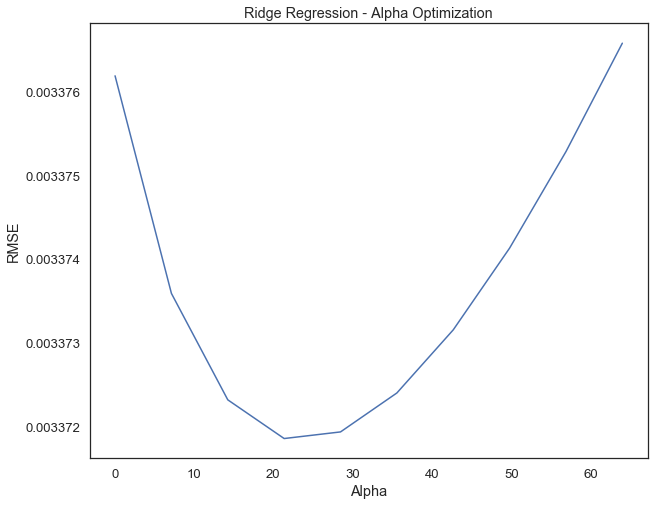

Best RMSE for Lasso Regression = 0.0045 for alpha = 0.03125


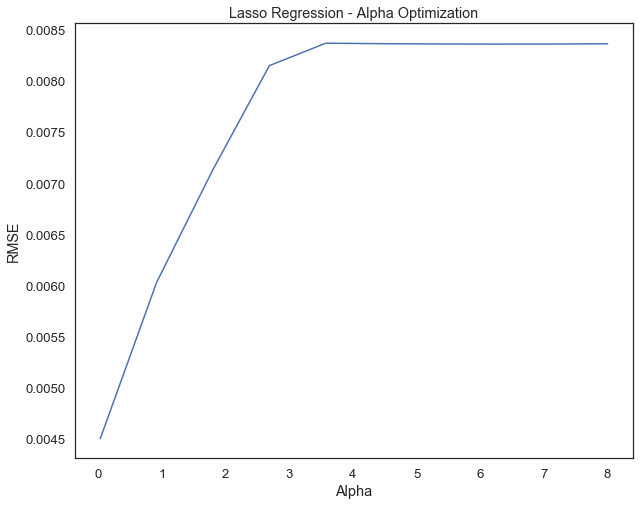

In [58]:
X_numeric = X[numeric_features]
X_numeric = X_numeric.fillna(X_numeric.mean())

model_ridge = Ridge()

alphas = np.linspace(2**(-5), 2**6, num=10)
cv_ridge = [rmse_cv(Ridge(alpha=alpha), X_numeric, y).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
sns.lineplot(x=alphas, y=cv_ridge)
plt.title("Ridge Regression - Alpha Optimization")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

print("Best RMSE for Ridge Regression = {:.4f} for alpha = {}".format(cv_ridge.min(), alphas[np.argmin(cv_ridge.values)]))
plt.show()

alphas = np.linspace(2**(-5), 2**3, num=10)
cv_lasso = [rmse_cv(Lasso(alpha=alpha), X_numeric, y).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index=alphas)
sns.lineplot(x=alphas, y=cv_lasso)
plt.title("Lasso Regression - Alpha Optimization")
plt.xlabel("Alpha")
plt.ylabel("RMSE")

print("Best RMSE for Lasso Regression = {:.4f} for alpha = {}".format(cv_lasso.min(), alphas[np.argmin(cv_lasso.values)]))
plt.show()

**LabelEncode the Ordinal Features**

Using the data description file, we can determine which categorical columns refer to ordinal characteristics, or those with an implied order.

In [56]:
ordinal_cols = ["ExterQual", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "LandSlope", "ExterCond", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC"]
nominal_cols = list(set(categorical_features.columns) - set(ordinal_cols))

In [62]:
label_encoder = LabelEncoder()
train[ordinal_cols] = train[ordinal_cols].apply(LabelEncoder().fit_transform)

TypeError: ('argument must be a string or number', 'occurred at index BsmtQual')

**One-Hot Encode the Nominal Features**

In [48]:
# https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding
train_dummies = pd.get_dummies(X[nominal_cols])
test_dummies = pd.get_dummies(test[nominal_cols])
train, test = train_dummies.align(test_dummies, join="left", axis=1)

KeyError: "None of [Index(['GarageType', 'Utilities', 'RoofStyle', 'Foundation', 'MSZoning',\n       'Condition2', 'Electrical', 'SaleType', 'LotShape', 'CentralAir',\n       'RoofMatl', 'BldgType', 'MasVnrType', 'LotConfig', 'Neighborhood',\n       'SaleCondition', 'Street', 'Heating', 'HouseStyle', 'Fence',\n       'LandContour', 'MiscFeature', 'Exterior2nd', 'Condition1', 'PavedDrive',\n       'Exterior1st', 'Alley'],\n      dtype='object')] are in the [columns]"